In [10]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
sns.set_theme(style="dark")
%matplotlib inline
''' %matplotlib inline sets the backend of matplotlib to
the 'inline' backend. When using the 'inline' backend,
your matplotlib graphs will be included in your notebook,
next to the code.'''

# # for creating a responsive plot
# %matplotlib ipympl
# %matplotlib widget

import  torch
import torch.nn.functional as F
'''
To get same results when sampling during different runs.
If you are using cuDNN, you should set the deterministic behavior.
This might make your code quite slow, but might be a good method to check your code and deactivate it later.
'''
torch.backends.cudnn.deterministic = True

In [11]:

words = open('names.txt', 'r').read().splitlines()

In [12]:
# sets takes an input, create a set of all items,
# & doesn't allow duplicates :)
# then we want a sorted list of course, the order matters! 
chars = sorted(list(set(''.join(words))))
# a map or dict:
# start from 1
s_to_i = { s:i for i, s in enumerate(chars, start=1)}
s_to_i['.'] = 0
i_to_s = { i:s for s,i in s_to_i.items()}

In [13]:
import itertools
def plot_heatmap(tensor, text=True, nrow=None, ncol=None, fig_size=(10,10)):
    if (nrow is None) or (ncol is None):
        nrow = tensor.shape[0]
        ncol = tensor.shape[1]
    plt.figure(figsize=fig_size)
    plt.imshow(tensor.detach().numpy(), cmap= 'Blues')
    # manually write text on each cell (seaborn annot doesn't look good)
    if text:
        for i, j in itertools.product(range(nrow), range(ncol)):
            # x:col, y:rows, the origin is top left corner, makes bottom <->top
            plt.text(x=j, y=i, s=f'{tensor[i,j].item():.2f}', ha='center', va='center', color='grey')
    plt.axis('off')

### 2D & 3d Embedding Visualization

In [14]:
def plot_2d_emb(emb_lkt, nclass, figsize=(8,8)):
    plt.figure(figsize=figsize)
    plt.scatter(x= emb_lkt[:,0].data, y=emb_lkt[:,1].data, s=200)
    for i in range(nclass):
        plt.text(x=emb_lkt[i,0].item(), y=emb_lkt[i,1].item(), s=i_to_s[i], ha='center', va='center', color='white')
    plt.grid('minor')

# def plot_3d_emb(emb_lkt, nclass, figsize=(8,8)):
#     tensor = emb_lkt.data.detach().numpy()
#     fig = plt.figure(figsize=figsize)
#     ax = Axes3D(fig)
#     ax.scatter(xs= tensor[:,0], ys=tensor[:,1], zs=tensor[:,2], s=200)
#     for i in range(nclass):
#         ax.text(x=tensor[i,0], y=tensor[i,1],z=tensor[i,2], s=i_to_s[i], ha='center', va='center', color='white')
#     # displaying the plot
#     plt.grid('minor')
#     plt.show()

## Splitting dataset into Training Dev & Test sets

1. split rate 80%, 10%, 10%

2. Dev or Validation set is for hyper parameter tuning

3. test should be touched at he end

In [15]:
WINDOW_SIZE = 5
NCLASS = 27

def build_dataset(words:list, type:str):
    xs, ys = [], []

    # context input window: how many characters do we take to predict the next one?
    

    for w in words:
        context_window = [0]*WINDOW_SIZE
        for ch in f'{w}.':
            idx_y = s_to_i[ch]
            ys.append(idx_y)

            xs.append(context_window) # input : ch1
            # print(''.join(i_to_s[i] for i in context_window) + f' ---> {ch}' )

            # shift_to_left context window and append the idx_y
            context_window = context_window[1:] + [idx_y]
    xs = torch.tensor(xs)
    # ys = torch.Tensor(ys)
    ys = torch.tensor(ys)
    print(f'{type}: {xs.shape = }')
    return xs, ys


import random
random.seed(42)
random.shuffle(words)
n80 = int( 0.8*len(words) )
n90 = int( 0.9*len(words) )
Xtr, Ytr = build_dataset(words[:n80], 'Tr')
Xdev, Ydev = build_dataset(words[n80:n90], 'Dev')
Xts, Yts = build_dataset(words[n90:], 'Ts')
TR_SIZE = Xtr.shape[0]
DEV_SIZE = Xdev.shape[0]
TS_SIZE = Xts.shape[0]
print(f'{TR_SIZE = }')
print(f'{WINDOW_SIZE = }')
print(f'{NCLASS = }')

Tr: xs.shape = torch.Size([182625, 5])
Dev: xs.shape = torch.Size([22655, 5])
Ts: xs.shape = torch.Size([22866, 5])
TR_SIZE = 182625
WINDOW_SIZE = 5
NCLASS = 27


# Activations & Gradients


## let's 1st see again the hidden layer without initialization or batch normalization

tanh function is a squashing function, it maps the input between -inf & +inf to a value between -1 & 1 .


So **`if the input to hidden layer got extreme values`** (like we had in weights and logits), **`then the output will be always -1 or 1`** !!


In [28]:
EMB_DIM = 5
HLAYER_SIZE = 300

g = torch.Generator().manual_seed(2147483647)
emb_lkt = torch.randn( NCLASS, EMB_DIM, generator=g)
W1 = torch.randn( WINDOW_SIZE*EMB_DIM, HLAYER_SIZE , generator=g)
b1 = torch.randn( HLAYER_SIZE, generator=g) * 0.01
W2 = torch.randn( HLAYER_SIZE, NCLASS, generator=g) * 0.01
b2 = torch.randn( NCLASS, generator=g) * 0.0
parameters = [emb_lkt, W1, b1, W2, b2]
for p in parameters:
    p.requires_grad = True
    p.grad = None
sum(p.nelement() for p in parameters)

16062

In [75]:
# This decorator disables gradient tracking for final training, dev, and test evaluation
# we don't optimize here
@torch.no_grad()
def evaluate_loss(ds_type, with_batchN = False): # ds_type: dataset type
    X,Y = {
        'train': (Xtr, Ytr),
        'dev': (Xdev, Ydev),
        'test': (Xts, Yts),
    }[ds_type]

    emb = emb_lkt[X] # BATCH_SIZE, WINDOW_SIZE, emb_dim
    hpreact = emb.view(-1, WINDOW_SIZE*EMB_DIM)@W1 + b1
    if with_batchN:
        hpreact = (hpreact - hpreact.mean(dim=0, keepdim=True)) / hpreact.std(dim=0, keepdim=True)
    
    h = torch.tanh(hpreact) # BATCH_SIZE, hlayer_size
    logits = h @ W2 + b2 # * log counts [BATCH_SIZE, NCLASS]
    
    loss = F.cross_entropy(logits, Y)
    print(f'{ds_type} loss: {loss.item()}')


In [29]:
lr = 0.1
BATCH_SIZE = 32
NSTEPS = 100000

# we don't need log loss anymore bc we don't have
# that hockey stick shape anymore
lossi = []
stepi = []

for i in range(NSTEPS):
    
    # Forward path
    mini_batch_idx = torch.randint(low=0, high=TR_SIZE, size=(BATCH_SIZE,))
    emb = emb_lkt[Xtr[mini_batch_idx]] # BATCH_SIZE, WINDOW_SIZE, emb_dim
    hpreact = emb.view(BATCH_SIZE, -1)@W1 + b1
    h = torch.tanh(hpreact) # BATCH_SIZE, HLAYER_SIZE
    logits = h @ W2 + b2 # * log counts [BATCH_SIZE, NCLASS]

    loss_mini = F.cross_entropy(logits, Ytr[mini_batch_idx])
    loss_mini.backward()

    lossi.append(loss_mini.log10().item())
    stepi.append(i)

    # update &
    for p in parameters:
        p.data -= lr*p.grad
        p.grad = None

    # track stats
    if i % 10000 == 0:
        print(f'iteration: {i:7d} / {NSTEPS:7d} | mini loss: {loss_mini.item():.4f}')
        break # intentionally added to stop to show the large loss

# print(f'loss_mini: {loss_mini.item()}')

iteration:       0 /  100000 | mini loss: 3.2978


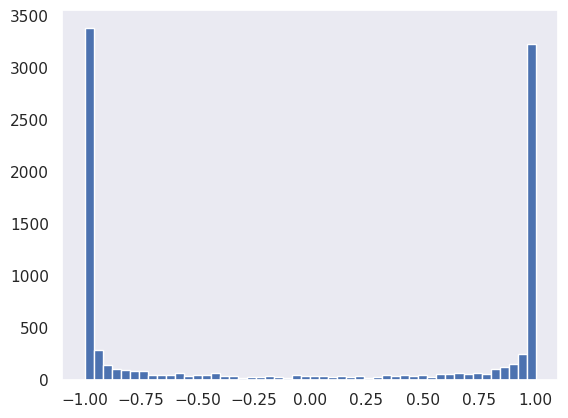

In [30]:
# most of the the values are -1 or +1
plt.hist(h.view(-1).tolist(), 50);

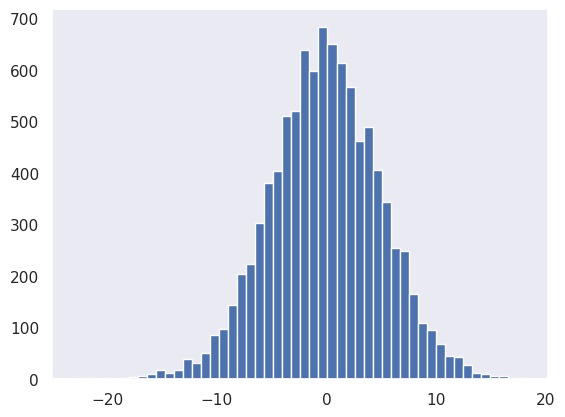

In [31]:
xs = np.arange(-5 ,5, 0.25)
plt.subplot(211)
plt.hist(hpreact.view(-1).tolist(), 50);
plt.subplot(212,sharex=ax1)
plt.plot(xs, np.tanh(xs))

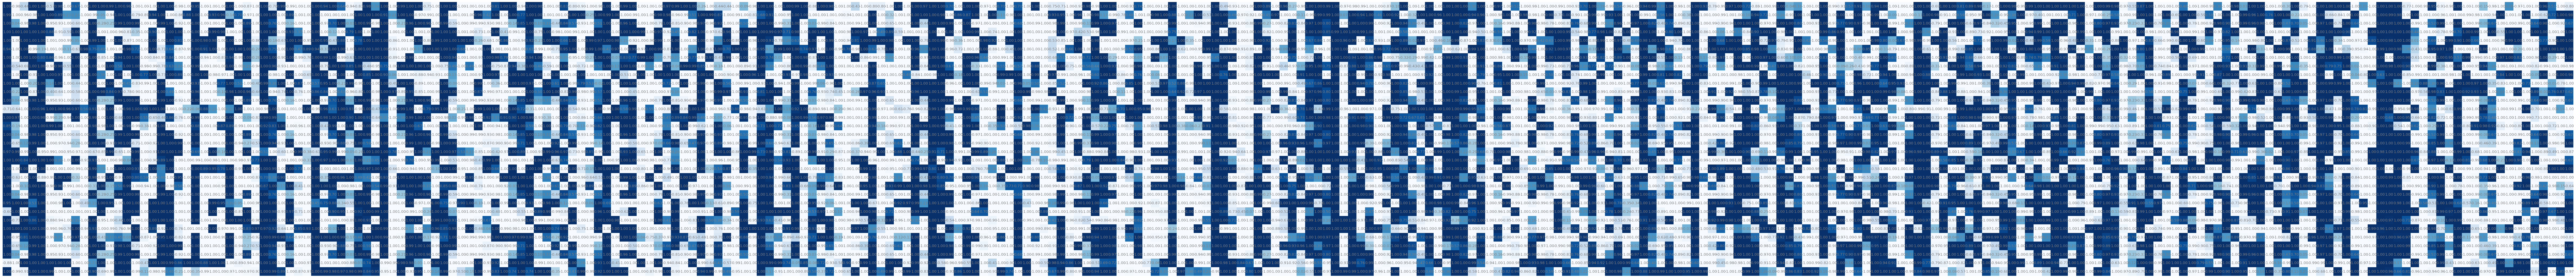

In [152]:
# expand the image and scrutinize it
plot_heatmap( h , text=False, fig_size=(150,350))

cols: Neurons HIDDEN LAYER

rows: samples in BATCH

if a Neuron blocks all gradients in the batch, it's literally dead !! it will never learn!!

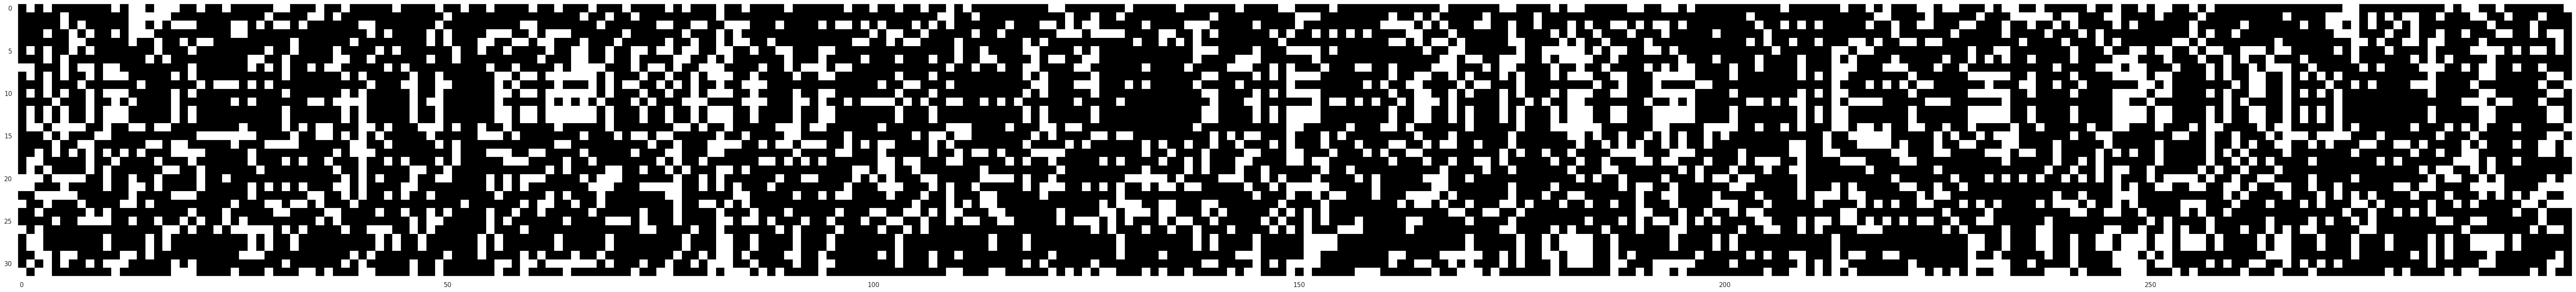

In [33]:
# let's create a boolean tensor to scrutinize the neurons
# open switches: white
# blocked switches: black
plt.figure(figsize=(80,40))
plt.imshow(h.abs() < 0.95, cmap='gray', interpolation='nearest')

# Batch Normalization
1- The idea comes from the paper by Sergey Loffe and Christian Szegedy in 2015.

2- **`The purpose is to control the distribution of the pre-activation at layers with Matrix Multiplication like MLP or ConvNets`**. Why??

bc **`The distribution of each layer's pre-activation or input changes during training, as the parameters of the previous layers (like embeddings) change`**. This phenomenon is **refered to as *`internal covariate shift`***

3- This slows down the training by requiring lower learning rates and careful parameter initialization and **`as size of the model increase, it becomes much harder to prevent preativations (firing values) get extreme values`**.

4- Here, we **`normalize layer pre-activations`** and make it a part of network architecture, and **`perform normalization for each training mini-batch`**. At the same time we want to **`let the model have the flexibility to find the best output distribution.`**

5- This allows you use higher learning rates and be less careful about initialization. It also act as a regularizer, in some cases, eliminate the need for Dropout.

## Pure Batch Normalization:
After pre activation, **`subtract the mean and divide by the std of the whole batch`**. these 2 operations are both differentiable, so no worries here!!

**`Both for the loss, and training`**!!!!

2 caveats regarding coding:

1- it's a good practice to consider an epsilon like 1e-5 to add to the batch std just in case of division by zero!

2- we are subtracting the mean from pre-activation, so whatever bias we add after emb*W1 + b1 , we subtract it here. **`We don't need any layer bias anymore`**

In [108]:
EMB_DIM = 5
HLAYER_SIZE = 300

g = torch.Generator().manual_seed(2147483647)
emb_lkt = torch.randn( NCLASS, EMB_DIM, generator=g)
W1 = torch.randn( WINDOW_SIZE*EMB_DIM, HLAYER_SIZE , generator=g) # * 5 / (3*(WINDOW_SIZE*EMB_DIM)**0.5)
# b1 = torch.randn( HLAYER_SIZE, generator=g) * 0.01
W2 = torch.randn( HLAYER_SIZE, NCLASS, generator=g) * 0.01
b2 = torch.randn( NCLASS, generator=g) * 0.0
# parameters = [emb_lkt, W1, b1, W2, b2]
parameters = [emb_lkt, W1, W2, b2]
for p in parameters:
    p.requires_grad = True
    p.grad = None
sum(p.nelement() for p in parameters)

16062

In [109]:
# This decorator disables gradient tracking for final training, dev, and test evaluation
# we don't optimize here
@torch.no_grad()
def evaluate_loss(ds_type, with_batchN = False): # ds_type: dataset type
    X,Y = {
        'train': (Xtr, Ytr),
        'dev': (Xdev, Ydev),
        'test': (Xts, Yts),
    }[ds_type]

    emb = emb_lkt[X] # BATCH_SIZE, WINDOW_SIZE, emb_dim
    hpreact = emb.view(-1, WINDOW_SIZE*EMB_DIM)@W1 #+ b1
    if with_batchN:
        hpreact = (hpreact - hpreact.mean(dim=0, keepdim=True)) / hpreact.std(dim=0, keepdim=True)
    
    h = torch.tanh(hpreact) # BATCH_SIZE, hlayer_size
    logits = h @ W2 + b2 # * log counts [BATCH_SIZE, NCLASS]
    
    loss = F.cross_entropy(logits, Y)
    print(f'{ds_type} loss: {loss.item()}')


In [110]:
lr = 0.1
BATCH_SIZE = 32
NSTEPS = 100000

# we don't need log loss anymore bc we don't have
# that hockey stick shape anymore
lossi = []
stepi = []

# just to prevent division by zero, in case the bn_std = 0
DIVISION0 = 1e-5

for i in range(NSTEPS):

    # Forward path
    mini_batch_idx = torch.randint(low=0, high=TR_SIZE, size=(BATCH_SIZE,))
    emb = emb_lkt[Xtr[mini_batch_idx]] # BATCH_SIZE, WINDOW_SIZE, emb_dim
    hpreact = emb.view(BATCH_SIZE, WINDOW_SIZE*EMB_DIM)@W1 #+ b1
    hpreact = (hpreact - hpreact.mean(dim=0, keepdim=True)) / (hpreact.std(dim=0, keepdim=True) + DIVISION0)
    h = torch.tanh(hpreact) # BATCH_SIZE, HLAYER_SIZE
    logits = h @ W2 + b2 # * log counts [BATCH_SIZE, NCLASS]

    loss_mini = F.cross_entropy(logits, Ytr[mini_batch_idx])
    loss_mini.backward()

    lossi.append(loss_mini.log10().item())
    stepi.append(i)

    # update &
    for p in parameters:
        p.data -= lr*p.grad
        p.grad = None

    # track stats
    if i % 10000 == 0:
        print(f'iteration: {i:7d} / {NSTEPS:7d} | mini loss: {loss_mini.item():.4f}')
        break # intentionally added to stop to show the large loss

# print(f'loss_mini: {loss_mini.item()}')

iteration:       0 /  100000 | mini loss: 3.2799


So we get **`a really good initialization`** we have:

1- a **`normal pre activation with mean=0 and std=1 which means we don't have extreme values,`**

2- and a more **`like a uniform output hayer (This depends on activation function!)`** This is bc of the squashing effect of tanh.

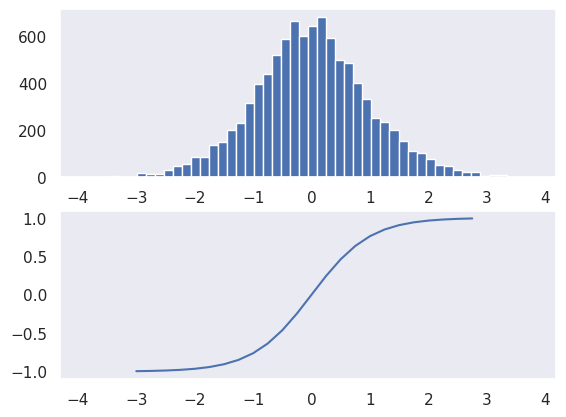

In [111]:
xs = np.arange(-3 ,3, 0.25)
ax1 = plt.subplot(211)
plt.hist(hpreact.view(-1).tolist(), 50);
plt.subplot(212, sharex=ax1)
plt.plot(xs, np.tanh(xs));

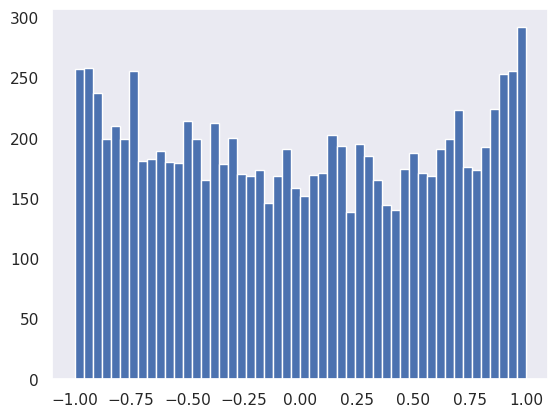

In [112]:
# most of the the values are -1 or +1
plt.hist(h.view(-1).tolist(), 50);

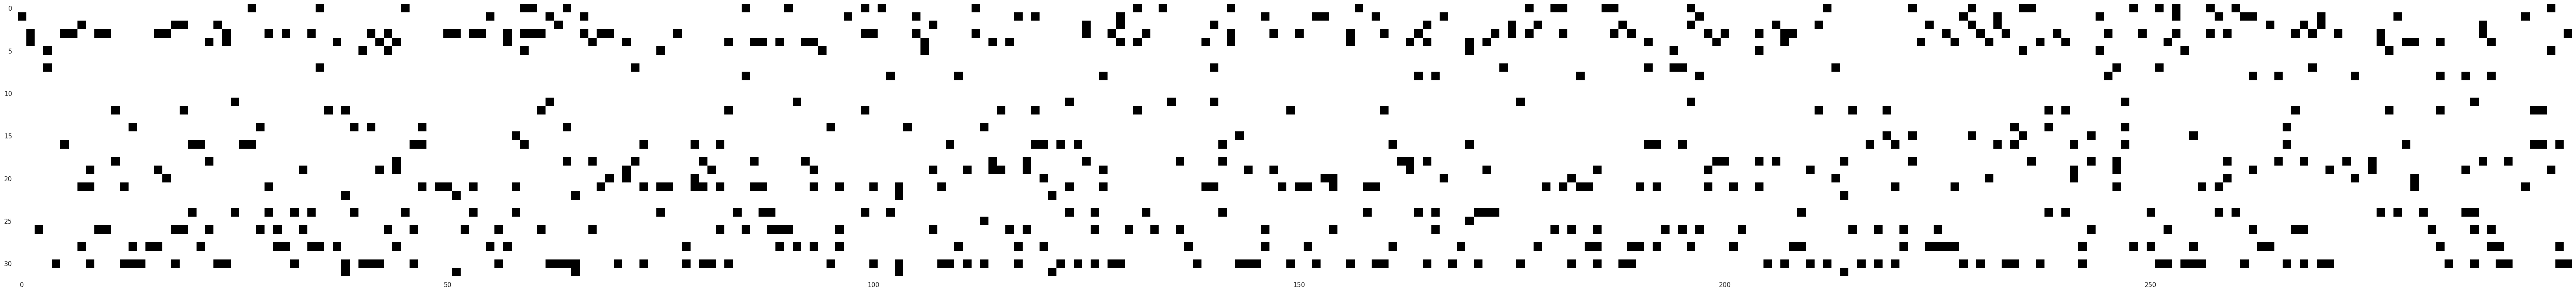

In [113]:
# let's create a boolean tensor to scrutinize the neurons
# open switches: white
# blocked switches: black
plt.figure(figsize=(80,40))
plt.imshow(h.abs() < 0.95, cmap='gray', interpolation='nearest')

### train the whole batch

In [114]:
lr = 0.1
BATCH_SIZE = 32
NSTEPS = 100000

# we don't need log loss anymore bc we don't have
# that hockey stick shape anymore
lossi = []
stepi = []

# just to prevent division by zero, in case the bn_std = 0
DIVISION0 = 1e-5

for i in range(NSTEPS):
    
    # Forward path
    mini_batch_idx = torch.randint(low=0, high=TR_SIZE, size=(BATCH_SIZE,))
    emb = emb_lkt[Xtr[mini_batch_idx]] # BATCH_SIZE, WINDOW_SIZE, emb_dim
    hpreact = emb.view(BATCH_SIZE, WINDOW_SIZE*EMB_DIM)@W1 #+ b1
    hpreact = (hpreact - hpreact.mean(dim=0, keepdim=True)) / (hpreact.std(dim=0, keepdim=True) + DIVISION0)
    h = torch.tanh(hpreact) # BATCH_SIZE, HLAYER_SIZE
    logits = h @ W2 + b2 # * log counts [BATCH_SIZE, NCLASS]

    loss_mini = F.cross_entropy(logits, Ytr[mini_batch_idx])
    loss_mini.backward()

    lossi.append(loss_mini.log10().item())
    stepi.append(i)

    # update &
    for p in parameters:
        p.data -= lr*p.grad
        p.grad = None

    # track stats
    if i % 10000 == 0:
        print(f'iteration: {i:7d} / {NSTEPS:7d} | mini loss: {loss_mini.item():.4f}')
        # break # intentionally added to stop to show the large loss

# print(f'loss_mini: {loss_mini.item()}')

iteration:       0 /  100000 | mini loss: 3.2580
iteration:   10000 /  100000 | mini loss: 2.5090
iteration:   20000 /  100000 | mini loss: 1.9861
iteration:   30000 /  100000 | mini loss: 2.1258
iteration:   40000 /  100000 | mini loss: 2.2633
iteration:   50000 /  100000 | mini loss: 2.4154
iteration:   60000 /  100000 | mini loss: 2.4269
iteration:   70000 /  100000 | mini loss: 2.4029
iteration:   80000 /  100000 | mini loss: 2.1324
iteration:   90000 /  100000 | mini loss: 2.3152


In [115]:
evaluate_loss('train', with_batchN=True)
evaluate_loss('dev', with_batchN=True)

train loss: 2.1544904708862305
dev loss: 2.193995475769043


1- **`the training took longer`**. Why?

1.1. remember **`we are computing the forwrad path (loss) for multiple samples in a batch, bc then we can compute the loss and backprop it for each sample in parallel`** with Matrix multiplication and then just sum them up at the end. ie. **`the forward and backward computation for each sample was independent of other samples in the batch`** and the low level kernel implement a single graph of operations for each sample and compute the loss and backprop gradient in parallel.

but now

1.2. we are computing the mean and std of pre-acts over the whole batch at each layer!! so **`they are not independent anymore`**!! now **`the kernel has to wait at each layer for all samples to finish the operation and do the mean and std.`** i.e to implement a huge common graph of operations **`for all random samples in the batch!`**

1.3- For this reason some other normalization methods came up to mitigate this property. like Layer normalization, Group normalization


2- Another interesting Point:

2.1- without updating the model parameters, since we have "random" samples in the batch, each specific sample have  different loss with different batches, but the same hidden representation and logits every time it is present in the batch. 

2.2- but now, without updating the model parameters, the sample get even different hidden representation, logits and loss with different batches. we can say it's like a jitter in the hidden representation, logits and prob of a sample. Is it good or bad?

2.3- well, think ot this jitter as an added noise or entropy, so if it's too much, it's bad. but if it's quite low, it can play a role as a regularizer and make it harder for the NN to overfit! like drop out!!


3- we achieved **`a better loss than no initialization or normalization!`**!! 

But, **it was a simple problem and a simple model**, it's not gonna work for hard problems and more complex models with different kinds of connections like Resnet, Why??

bc we are reducing the flexibility of the model **`we want it to be able to scale and shift the Gaussian input`**

we want the NN to learn by itself the correct distribution of the output layer, but **`we are forcing it to produce a uniform-like all the time, therefore we won't see any change in the output distribution!!`**

look at distributions it's the same!

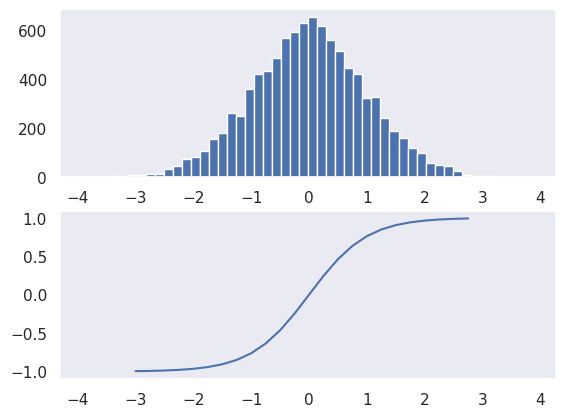

In [116]:
xs = np.arange(-3 ,3, 0.25)
ax1 = plt.subplot(211)
plt.hist(hpreact.view(-1).tolist(), 50);
plt.subplot(212, sharex=ax1)
plt.plot(xs, np.tanh(xs));

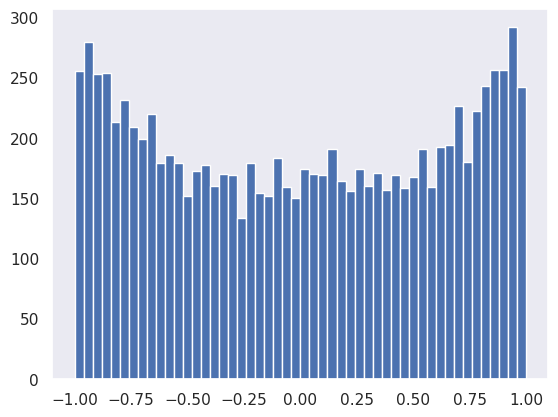

In [117]:
# most of the the values are -1 or +1
plt.hist(h.view(-1).tolist(), 50);

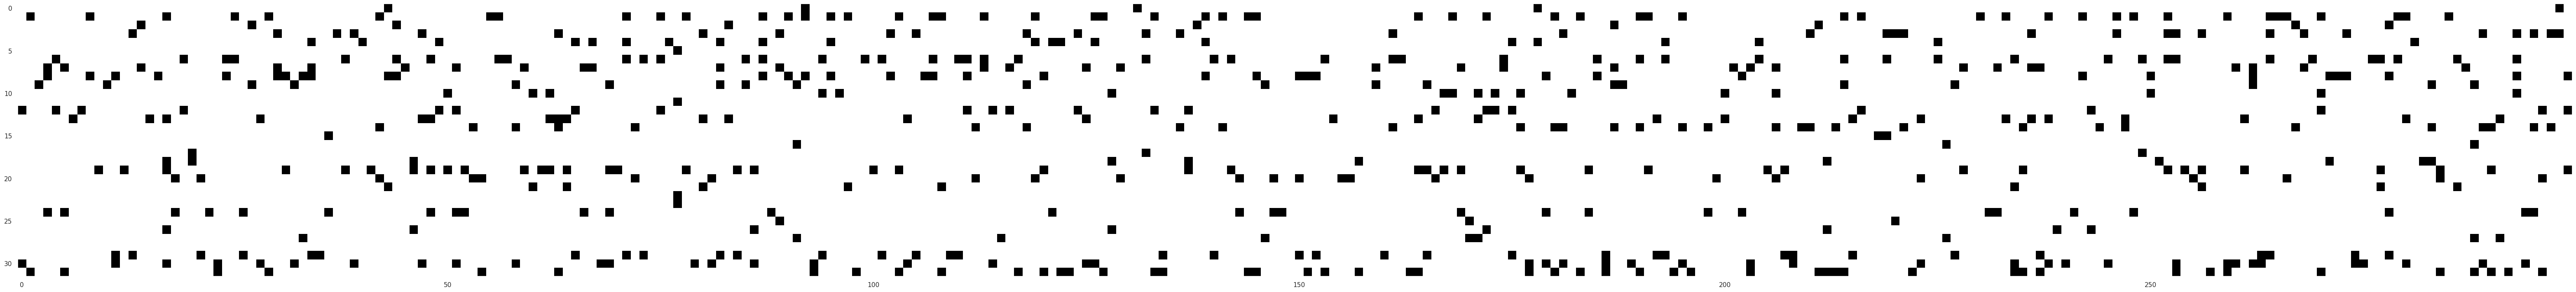

In [118]:
# let's create a boolean tensor to scrutinize the neurons
# open switches: white
# blocked switches: black
plt.figure(figsize=(80,40))
plt.imshow(h.abs() < 0.95, cmap='gray', interpolation='nearest');

## Batch Normalization with scale & shift

Now we **`let the model to scale (add gain) and move (add bias) the pre-activation gaussian`** to find a correct distribution of the tanh output.

so for each neuron in the hidden layer, we want to add a gain and a bias (I know they already have a bias!!) **`initialized first with no effect`**, so we initialize the gain as ones and bias as zeros. so let's jump right into training whole batch

but we want the model to find the correct value for them (add them to your parameters)

In [119]:
EMB_DIM = 5
HLAYER_SIZE = 300

g = torch.Generator().manual_seed(2147483647)
emb_lkt = torch.randn( NCLASS, EMB_DIM, generator=g)
W1 = torch.randn( WINDOW_SIZE*EMB_DIM, HLAYER_SIZE , generator=g) #* 5 / (3*(WINDOW_SIZE*EMB_DIM)**0.5)
# b1 = torch.randn( HLAYER_SIZE, generator=g) * 0.01
W2 = torch.randn( HLAYER_SIZE, NCLASS, generator=g) * 0.01
b2 = torch.randn( NCLASS, generator=g) * 0.0

bn_gain = torch.ones(1, HLAYER_SIZE)
bn_bias = torch.zeros(1, HLAYER_SIZE)

parameters = [emb_lkt, W1, W2, b2, bn_gain , bn_bias]
for p in parameters:
    p.requires_grad = True
    p.grad = None
sum(p.nelement() for p in parameters)

16662

modify both the loss function and the training

In [120]:
# This decorator disables gradient tracking for final training, dev, and test evaluation
# we don't optimize here
@torch.no_grad()
def evaluate_loss(ds_type, with_batchN = False): # ds_type: dataset type
    X,Y = {
        'train': (Xtr, Ytr),
        'dev': (Xdev, Ydev),
        'test': (Xts, Yts),
    }[ds_type]

    emb = emb_lkt[X] # BATCH_SIZE, WINDOW_SIZE, emb_dim
    hpreact = emb.view(-1, WINDOW_SIZE*EMB_DIM)@W1 #+ b1
    if with_batchN:
        hpreact = bn_bias + bn_gain * (hpreact - hpreact.mean(dim=0, keepdim=True)) / hpreact.std(dim=0, keepdim=True)
    
    h = torch.tanh(hpreact) # BATCH_SIZE, hlayer_size
    logits = h @ W2 + b2 # * log counts [BATCH_SIZE, NCLASS]
    
    loss = F.cross_entropy(logits, Y)
    print(f'{ds_type} loss: {loss.item()}')


In [121]:
lr = 0.1
BATCH_SIZE = 32
NSTEPS = 100000

# we don't need log loss anymore bc we don't have
# that hockey stick shape anymore
lossi = []
stepi = []

# just to prevent division by zero, in case the bn_std = 0
DIVISION0 = 1e-5

for i in range(NSTEPS):
    
    # Forward path
    mini_batch_idx = torch.randint(low=0, high=TR_SIZE, size=(BATCH_SIZE,))
    emb = emb_lkt[Xtr[mini_batch_idx]] # BATCH_SIZE, WINDOW_SIZE, emb_dim
    hpreact = emb.view(BATCH_SIZE, WINDOW_SIZE*EMB_DIM)@W1 #+ b1
    hpreact = bn_bias + bn_gain * (hpreact - hpreact.mean(dim=0, keepdim=True)) / (hpreact.std(dim=0, keepdim=True) + DIVISION0)
    h = torch.tanh(hpreact) # BATCH_SIZE, HLAYER_SIZE
    logits = h @ W2 + b2 # * log counts [BATCH_SIZE, NCLASS]

    loss_mini = F.cross_entropy(logits, Ytr[mini_batch_idx])
    loss_mini.backward()

    lossi.append(loss_mini.log10().item())
    stepi.append(i)

    # update &
    for p in parameters:
        p.data -= lr*p.grad
        p.grad = None

    # track stats
    if i % 10000 == 0:
        print(f'iteration: {i:7d} / {NSTEPS:7d} | mini loss: {loss_mini.item():.4f}')
        # break # intentionally added to stop to show the large loss

# print(f'loss_mini: {loss_mini.item()}')

iteration:       0 /  100000 | mini loss: 3.3135
iteration:   10000 /  100000 | mini loss: 1.9064
iteration:   20000 /  100000 | mini loss: 2.0652
iteration:   30000 /  100000 | mini loss: 2.2976
iteration:   40000 /  100000 | mini loss: 1.8425
iteration:   50000 /  100000 | mini loss: 2.2010
iteration:   60000 /  100000 | mini loss: 1.9181
iteration:   70000 /  100000 | mini loss: 2.1711
iteration:   80000 /  100000 | mini loss: 1.9420
iteration:   90000 /  100000 | mini loss: 2.3006


In [122]:
evaluate_loss('train', with_batchN=True)
evaluate_loss('dev', with_batchN=True)

train loss: 2.1323981285095215
dev loss: 2.165257453918457


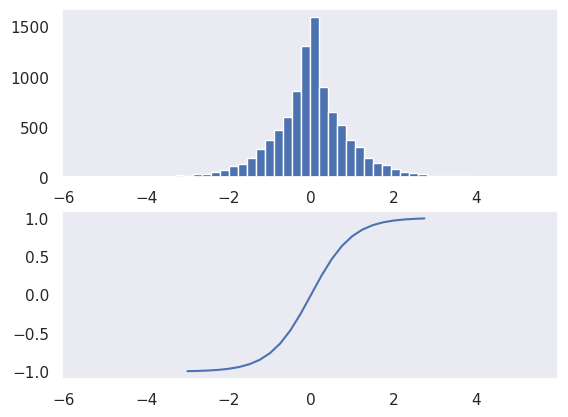

In [123]:
xs = np.arange(-3 ,3, 0.25)
ax1 = plt.subplot(211)
plt.hist(hpreact.view(-1).tolist(), 50);
plt.subplot(212, sharex=ax1)
plt.plot(xs, np.tanh(xs));

In [ ]:
plt.plot(stepi, lossi)

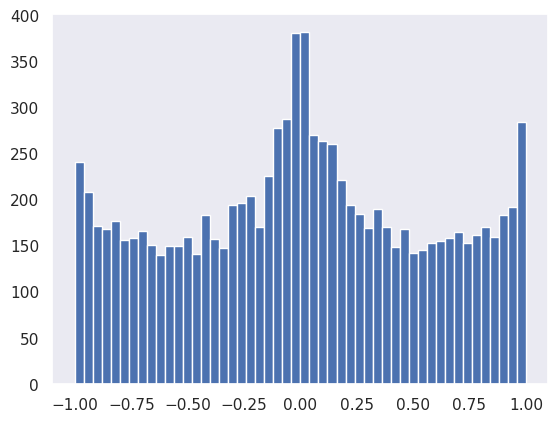

In [126]:
# most of the the values are -1 or +1
plt.hist(h.view(-1).tolist(), 50);

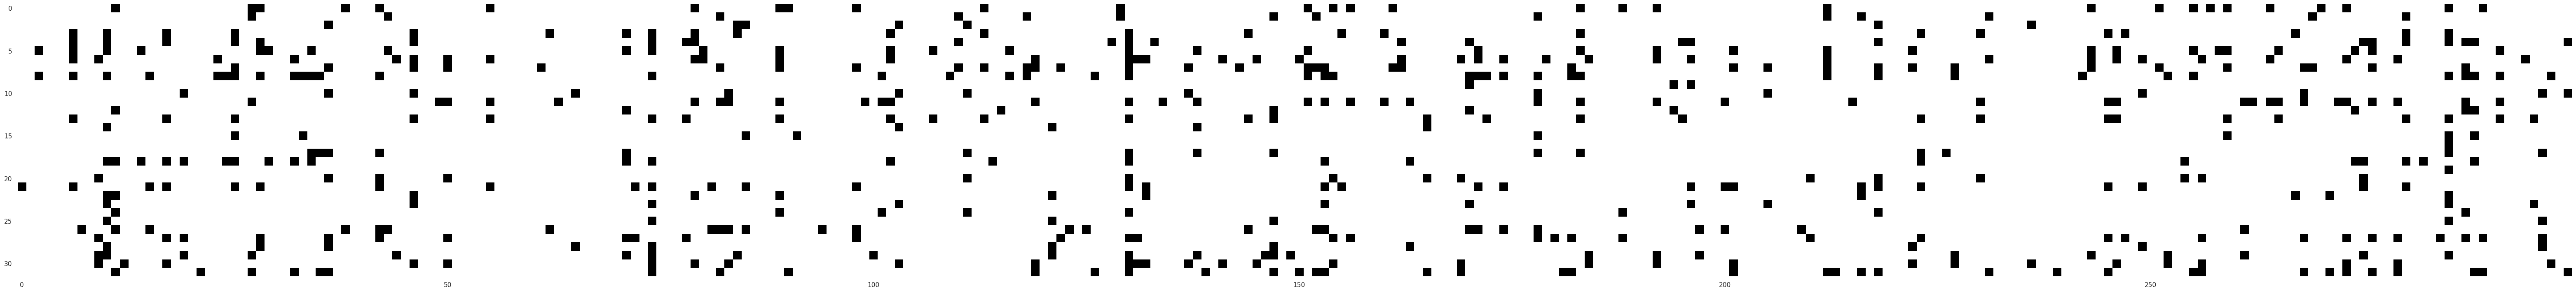

In [127]:
# let's create a boolean tensor to scrutinize the neurons
# open switches: white
# blocked switches: black
plt.figure(figsize=(80,40))
plt.imshow(h.abs() < 0.95, cmap='gray', interpolation='nearest');

### 4- How to do inference or validation for a single sample without a batch?

One way is that, after training is done and before inference, compute the batch norms ( mean and std of hidden layers) for all training dataset for single time and use that fixed mean and std instead.

but come on, who would do that, we are lazy!!, with Peta Bytes of data !! 

In the paper, they also used exponential moving average to compute the mean and std during training (in a rolling manner or recursively (like rolling Pandas) )

the lower the BATCH_SIZE the lower the MOMENTUM!!
:

In [142]:
EMB_DIM = 5
HLAYER_SIZE = 300

g = torch.Generator().manual_seed(2147483647)
emb_lkt = torch.randn( NCLASS, EMB_DIM, generator=g)
W1 = torch.randn( WINDOW_SIZE*EMB_DIM, HLAYER_SIZE , generator=g) #* 5 / (3*(WINDOW_SIZE*EMB_DIM)**0.5)
# b1 = torch.randn( HLAYER_SIZE, generator=g) * 0.01
W2 = torch.randn( HLAYER_SIZE, NCLASS, generator=g) * 0.01
b2 = torch.randn( NCLASS, generator=g) * 0.0

bn_gain = torch.ones(1, HLAYER_SIZE)
bn_bias = torch.zeros(1, HLAYER_SIZE)

# these are not model params, we update them recursively
bn_mean_ema = torch.zeros(1, HLAYER_SIZE)
bn_std_ema = torch.ones(1, HLAYER_SIZE)

parameters = [emb_lkt, W1, W2, b2, bn_gain , bn_bias]
for p in parameters:
    p.requires_grad = True
    p.grad = None
sum(p.nelement() for p in parameters)

16362

modify both the loss function and the training

In [143]:
# This decorator disables gradient tracking for final training, dev, and test evaluation
# we don't optimize here
@torch.no_grad()
def evaluate_loss(ds_type, with_batchN = False): # ds_type: dataset type
    X,Y = {
        'train': (Xtr, Ytr),
        'dev': (Xdev, Ydev),
        'test': (Xts, Yts),
    }[ds_type]

    emb = emb_lkt[X] # BATCH_SIZE, WINDOW_SIZE, emb_dim
    hpreact = emb.view(-1, WINDOW_SIZE*EMB_DIM)@W1 #+ b1
    if with_batchN:
        hpreact = bn_bias + bn_gain * (hpreact - bn_mean_ema) / bn_std_ema
    
    h = torch.tanh(hpreact) # BATCH_SIZE, hlayer_size
    logits = h @ W2 + b2 # * log counts [BATCH_SIZE, NCLASS]
    
    loss = F.cross_entropy(logits, Y)
    print(f'{ds_type} loss: {loss.item()}')


In [144]:
lr = 0.1
BATCH_SIZE = 32
NSTEPS = 100000

# we don't need log loss anymore bc we don't have
# that hockey stick shape anymore
lossi = []
stepi = []

# just to prevent division by zero, in case the bn_std = 0
DIVISION0 = 1e-5
# momentum for moving average
# the lower the BATCH_SIZE the lower the MOMENTUM!!
MOMENTUM = 0.001

for i in range(NSTEPS):
    
    # Forward path
    mini_batch_idx = torch.randint(low=0, high=TR_SIZE, size=(BATCH_SIZE,))
    emb = emb_lkt[Xtr[mini_batch_idx]] # BATCH_SIZE, WINDOW_SIZE, emb_dim
    hpreact = emb.view(BATCH_SIZE, WINDOW_SIZE*EMB_DIM)@W1 #+ b1  # BATCH_SIZE, HLAYER_SIZE

    bn_meani = hpreact.mean(dim=0, keepdim=True)
    bn_stdi = hpreact.std(dim=0, keepdim=True)
    
    hpreact = bn_bias + bn_gain * (hpreact - bn_meani) / (bn_stdi + DIVISION0)
    
    # What would happen if you forget no_grad!!
    with torch.no_grad(): # don't build a graph here
        # pass the training set through
        bn_mean_ema = (1-MOMENTUM) * bn_mean_ema + MOMENTUM * bn_meani
        bn_std_ema = (1-MOMENTUM) * bn_std_ema + MOMENTUM * bn_stdi
    
    h = torch.tanh(hpreact) # BATCH_SIZE, HLAYER_SIZE
    logits = h @ W2 + b2 # * log counts [BATCH_SIZE, NCLASS]

    loss_mini = F.cross_entropy(logits, Ytr[mini_batch_idx])
    loss_mini.backward()

    lossi.append(loss_mini.log10().item())
    stepi.append(i)

    # update &
    for p in parameters:
        p.data -= lr*p.grad
        p.grad = None

    # track stats
    if i % 10000 == 0:
        print(f'iteration: {i:7d} / {NSTEPS:7d} | mini loss: {loss_mini.item():.4f}')
        # break # intentionally added to stop to show the large loss


iteration:       0 /  100000 | mini loss: 3.3067
iteration:   10000 /  100000 | mini loss: 2.0580
iteration:   20000 /  100000 | mini loss: 2.3318
iteration:   30000 /  100000 | mini loss: 2.3594
iteration:   40000 /  100000 | mini loss: 2.0729
iteration:   50000 /  100000 | mini loss: 2.1825
iteration:   60000 /  100000 | mini loss: 2.4679
iteration:   70000 /  100000 | mini loss: 2.2701
iteration:   80000 /  100000 | mini loss: 2.4660
iteration:   90000 /  100000 | mini loss: 2.0613


In [145]:
evaluate_loss('train', with_batchN=True)
evaluate_loss('dev', with_batchN=True)

train loss: 2.154451370239258
dev loss: 2.1889421939849854


In [146]:
# rolling mean and std are almost equal to the exact value
@torch.no_grad()
def compare_ema(emb_lkt, bn_mean_ema, bn_std_ema):
    emb = emb_lkt[Xtr] # DATASET_SIZE, WINDOW_SIZE, EMD_DIM
    hpreact = emb.view(-1, WINDOW_SIZE*EMB_DIM)@W1 #+ b1
    bn_mean = hpreact.mean(dim=0, keepdim=True) # bias
    bn_std = hpreact.std(dim=0, keepdim=True)# scale
    print((bn_mean - bn_mean_ema).mean(), (bn_mean - bn_mean_ema).std() )
    print((bn_std - bn_std_ema).mean(), (bn_std - bn_std_ema).std() )

# going into local scale parameters to not change the global ones
compare_ema(emb_lkt, bn_mean_ema, bn_std_ema)

tensor(-0.0223) tensor(0.1176)
tensor(0.0256) tensor(0.0412)


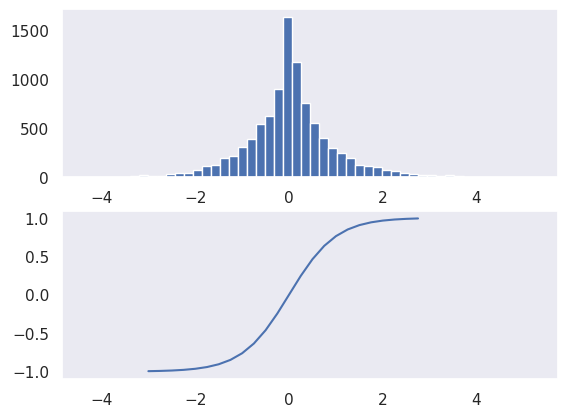

In [147]:
xs = np.arange(-3 ,3, 0.25)
ax1 = plt.subplot(211)
plt.hist(hpreact.view(-1).tolist(), 50);
plt.subplot(212, sharex=ax1)
plt.plot(xs, np.tanh(xs));

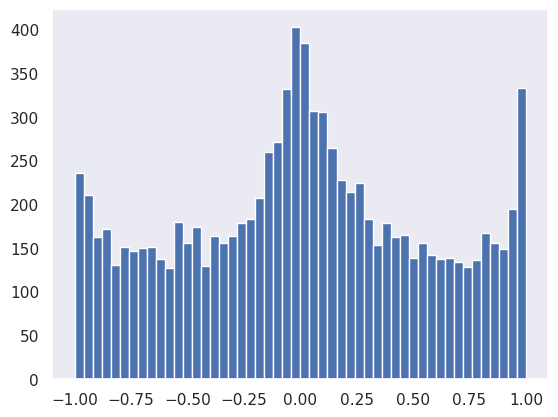

In [148]:
# most of the the values are -1 or +1
plt.hist(h.view(-1).tolist(), 50);

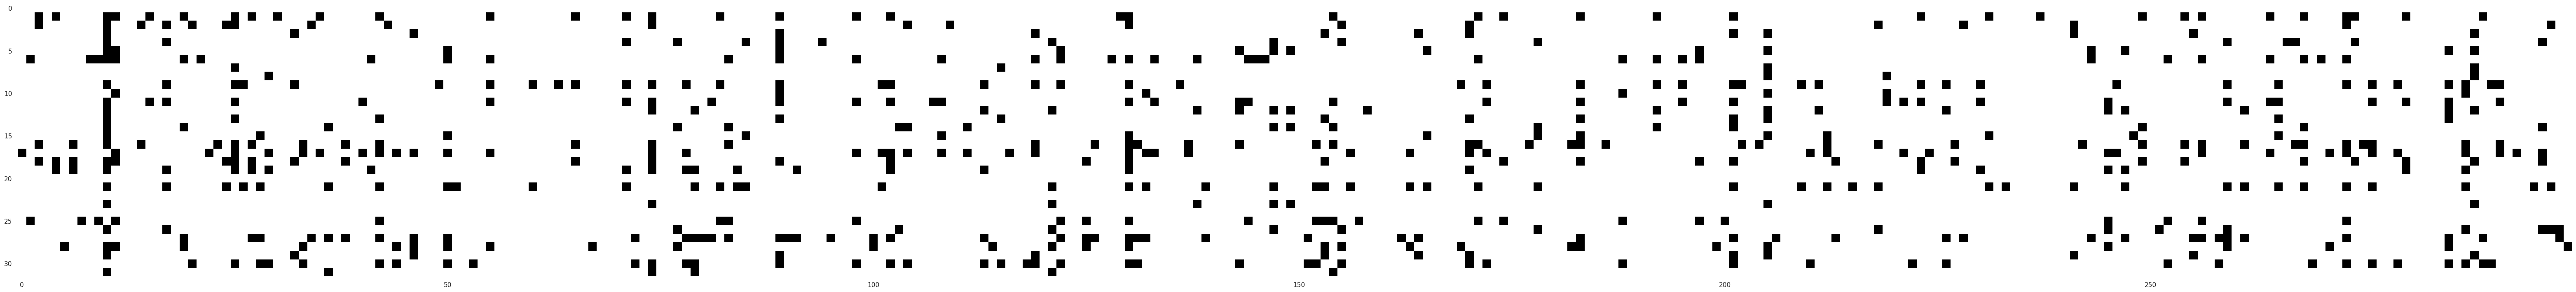

In [149]:
# let's create a boolean tensor to scrutinize the neurons
# open switches: white
# blocked switches: black
plt.figure(figsize=(80,40))
plt.imshow(h.abs() < 0.95, cmap='gray', interpolation='nearest');

# Batch Norm with Weight Initialization

In [150]:
EMB_DIM = 5
HLAYER_SIZE = 300

g = torch.Generator().manual_seed(2147483647)
emb_lkt = torch.randn( NCLASS, EMB_DIM, generator=g)
W1 = torch.randn( WINDOW_SIZE*EMB_DIM, HLAYER_SIZE , generator=g) * 5 / (3*(WINDOW_SIZE*EMB_DIM)**0.5)
# b1 = torch.randn( HLAYER_SIZE, generator=g) * 0.01
W2 = torch.randn( HLAYER_SIZE, NCLASS, generator=g) * 0.01
b2 = torch.randn( NCLASS, generator=g) * 0.0

bn_gain = torch.ones(1, HLAYER_SIZE)
bn_bias = torch.zeros(1, HLAYER_SIZE)

# these are not model params, we update them recursively
bn_mean_ema = torch.zeros(1, HLAYER_SIZE)
bn_std_ema = torch.ones(1, HLAYER_SIZE)

parameters = [emb_lkt, W1, W2, b2, bn_gain , bn_bias]
for p in parameters:
    p.requires_grad = True
    p.grad = None
sum(p.nelement() for p in parameters)

16362

In [151]:
# This decorator disables gradient tracking for final training, dev, and test evaluation
# we don't optimize here
@torch.no_grad()
def evaluate_loss(ds_type, with_batchN = False): # ds_type: dataset type
    X,Y = {
        'train': (Xtr, Ytr),
        'dev': (Xdev, Ydev),
        'test': (Xts, Yts),
    }[ds_type]

    emb = emb_lkt[X] # BATCH_SIZE, WINDOW_SIZE, emb_dim
    hpreact = emb.view(-1, WINDOW_SIZE*EMB_DIM)@W1 #+ b1
    if with_batchN:
        hpreact = bn_bias + bn_gain * (hpreact - bn_mean_ema) / bn_std_ema
    
    h = torch.tanh(hpreact) # BATCH_SIZE, hlayer_size
    logits = h @ W2 + b2 # * log counts [BATCH_SIZE, NCLASS]
    
    loss = F.cross_entropy(logits, Y)
    print(f'{ds_type} loss: {loss.item()}')


In [152]:
lr = 0.1
BATCH_SIZE = 32
NSTEPS = 100000

# we don't need log loss anymore bc we don't have
# that hockey stick shape anymore
lossi = []
stepi = []

# just to prevent division by zero, in case the bn_std = 0
DIVISION0 = 1e-5
# momentum for moving average
# the lower the BATCH_SIZE the lower the MOMENTUM!!
MOMENTUM = 0.001

for i in range(NSTEPS):
    
    # Forward path
    mini_batch_idx = torch.randint(low=0, high=TR_SIZE, size=(BATCH_SIZE,))
    emb = emb_lkt[Xtr[mini_batch_idx]] # BATCH_SIZE, WINDOW_SIZE, emb_dim
    hpreact = emb.view(BATCH_SIZE, WINDOW_SIZE*EMB_DIM)@W1 #+ b1

    bn_meani = hpreact.mean(dim=0, keepdim=True)
    bn_stdi = hpreact.std(dim=0, keepdim=True)
    
    hpreact = bn_bias + bn_gain * (hpreact - bn_meani) / (bn_stdi + DIVISION0)
    
    # What would happen if you forget no_grad!!
    with torch.no_grad(): # don't build a graph here
        # pass the training set through
        bn_mean_ema = (1-MOMENTUM) * bn_mean_ema + MOMENTUM * bn_meani
        bn_std_ema = (1-MOMENTUM) * bn_std_ema + MOMENTUM * bn_stdi
    
    h = torch.tanh(hpreact) # BATCH_SIZE, HLAYER_SIZE
    logits = h @ W2 + b2 # * log counts [BATCH_SIZE, NCLASS]

    loss_mini = F.cross_entropy(logits, Ytr[mini_batch_idx])
    loss_mini.backward()

    lossi.append(loss_mini.log10().item())
    stepi.append(i)

    # update &
    for p in parameters:
        p.data -= lr*p.grad
        p.grad = None

    # track stats
    if i % 10000 == 0:
        print(f'iteration: {i:7d} / {NSTEPS:7d} | mini loss: {loss_mini.item():.4f}')
        # break # intentionally added to stop to show the large loss


iteration:       0 /  100000 | mini loss: 3.3339
iteration:   10000 /  100000 | mini loss: 1.9701
iteration:   20000 /  100000 | mini loss: 2.2065
iteration:   30000 /  100000 | mini loss: 2.0806
iteration:   40000 /  100000 | mini loss: 2.1072
iteration:   50000 /  100000 | mini loss: 2.0746
iteration:   60000 /  100000 | mini loss: 2.5407
iteration:   70000 /  100000 | mini loss: 1.8683
iteration:   80000 /  100000 | mini loss: 1.7972
iteration:   90000 /  100000 | mini loss: 2.4234


In [153]:
evaluate_loss('train', with_batchN=True)
evaluate_loss('dev', with_batchN=True)

train loss: 2.0911338329315186
dev loss: 2.1410610675811768


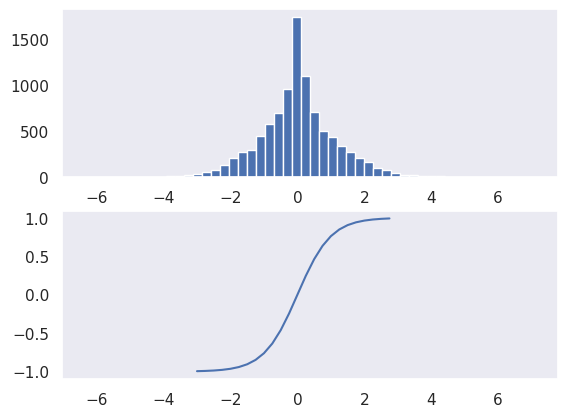

In [154]:
xs = np.arange(-3 ,3, 0.25)
ax1 = plt.subplot(211)
plt.hist(hpreact.view(-1).tolist(), 50);
plt.subplot(212, sharex=ax1)
plt.plot(xs, np.tanh(xs));

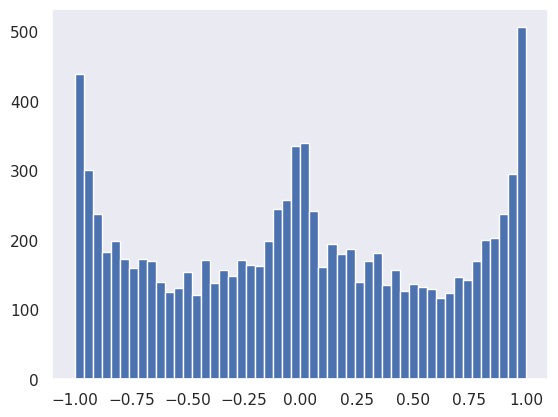

In [155]:
# most of the the values are -1 or +1
plt.hist(h.view(-1).tolist(), 50);

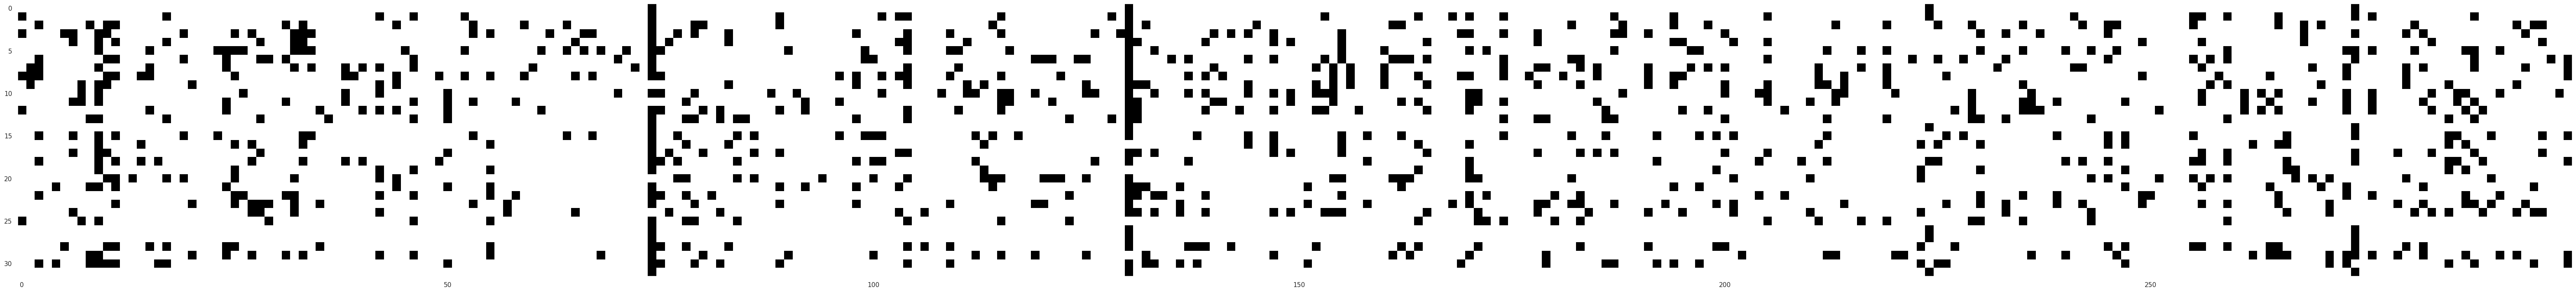

In [156]:
# let's create a boolean tensor to scrutinize the neurons
# open switches: white
# blocked switches: black
plt.figure(figsize=(80,40))
plt.imshow(h.abs() < 0.95, cmap='gray', interpolation='nearest');

## Hyperparameter Tuning

1- if the training loss is roughly equal (.2f) to the dev loss, it means the model is under-fitted. it's not big enough to just purely memorizes the data. so we can scale the model and increase the number of parameters, meaning the size of hidden layer and embeddings.

2- On the other side, if your overfitting to traing data set, it means the model is to big and over-parameterized. so you have 2 options find a larger dataset, or lower the number of parameters.

Also tune the lr here! first continue with 0.1 till you don't improvement in the total train loss then go with 0.01 and lower. see the dev_loss as well.

In [15]:
EMB_DIM = 3
HLAYER_SIZE = 300

g = torch.Generator().manual_seed(2147483647)
emb_lkt = torch.randn( NCLASS, EMB_DIM, generator=g)
W1 = torch.randn( WINDOW_SIZE*EMB_DIM, HLAYER_SIZE , generator=g)
b1 = torch.randn( HLAYER_SIZE, generator=g)
W2 = torch.randn( HLAYER_SIZE, NCLASS, generator=g)
b2 = torch.randn( NCLASS, generator=g)
parameters = [emb_lkt, W1, b1, W2, b2]
for p in parameters:
    p.requires_grad = True
    p.grad = None
sum(p.nelement() for p in parameters)

10881

### increasing the size of Embeddings
Also tune the lr here! first continue with 0.1 till you don't improvement in the total train loss then go with 0.01 and lower. see the dev_loss as well.

In [50]:
lri = []
lr_expo = torch.linspace(start=-3, end=0, steps=1000)
exponential_lr = 10**lr_expo

BATCH_SIZE = 32
loglossi = []
stepi = []

NSTEPS = 10000

for i in range(NSTEPS):
    
    # Forward path
    mini_batch_idx = torch.randint(low=0, high=TR_SIZE, size=(BATCH_SIZE,))
    emb = emb_lkt[Xtr[mini_batch_idx]] # BATCH_SIZE, WINDOW_SIZE, emb_dim
    h = torch.tanh(emb.view(BATCH_SIZE, WINDOW_SIZE*EMB_DIM)@W1 + b1 ) # BATCH_SIZE, hlayer_size
    logits = h @ W2 + b2 # * log counts [BATCH_SIZE, NCLASS]
    # counts = logits.exp() # * equivalent to counts [b, NCLASS]
    # probs = counts / counts.sum(dim=1 , keepdim=True) #[b, NCLASS]
     
    # loss = -probs[torch.arange(BATCH_SIZE), ys].log().mean() + l2coef*(W**2).mean()

    loss_mini = F.cross_entropy(logits, Ytr[mini_batch_idx])
    
    loglossi.append(loss_mini.log10().item())
    stepi.append(i)

    lr = exponential_lr[i]
    lri.append(lr_expo[i]) # store the exponent

    loss_mini.backward()

    # update &
    # set the weight grads to None, PyTorch interpret it as 0
    # but None is more efficient
    for p in parameters:
        p.data -= lr*p.grad
        p.grad = None

    # print(f'iteration: {i} | loss: {loss.item()}')

print(f'loss_mini: {loss_mini.item()}')

loss_mini: 1.905316710472107


In [ ]:
evaluate_loss('train')
evaluate_loss('dev')

In [ ]:
plt.plot(lri, loglossi)

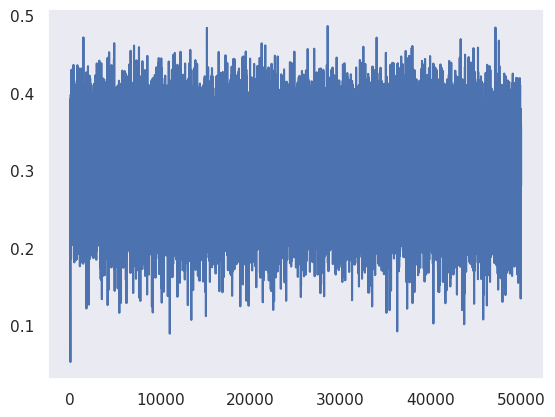

In [51]:
plt.plot(stepi, loglossi)

## Let's Generate some samples like Bigram

In [157]:

g = torch.Generator().manual_seed(2147483647)
for _ in range(10):
    idx_y = 0
    name = ''
    context_window = [0]*WINDOW_SIZE
    
    while True:
        # Forward path
        emb = emb_lkt[torch.tensor([context_window])] # BATCH_SIZE=1, WINDOW_SIZE, emb_dim
        
        hpreact = emb.view(-1, WINDOW_SIZE*EMB_DIM)@W1 #+ b1
        
        hpreact = bn_bias + bn_gain * (hpreact - bn_mean_ema) / bn_std_ema

        h = torch.tanh(hpreact)

        logits = h @ W2 + b2 # * log counts [BATCH_SIZE, NCLASS]
        probs = F.softmax(logits, dim=1)
        
        idx_y = torch.multinomial(probs.detach(), num_samples=1, replacement=True, generator=g).item()
        # shift_to_left context window and append the idx_y
        context_window = context_window[1:] + [idx_y]
        if idx_y == 0:
            break
        ch = i_to_s[idx_y]
        # print(ch)
        name += ch
    print(name)

moncato
milex
spurin
knista
said
melserwaril
paisii
jailen
dakerik
shaqee
